In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm
import re
import skimage.transform

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cpu


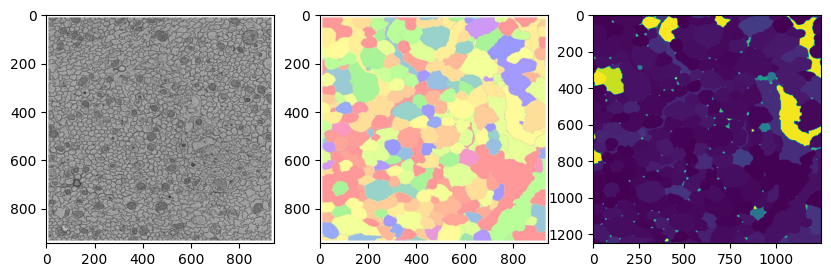

In [4]:
data_dir = os.path.join(".","plain")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

def extract_integers(s):
    return [int(num) for num in re.findall(r'\d+', s)]

def check_index(search_lst):
    intlst = []
    for i in search_lst:
        if i != ".DS_Store":
            intlst.append(extract_integers(i)[0])
    unique_lst = list(set(intlst))
    unique_lst.sort()
    return unique_lst

def image_open(dir, num, backbone):
    img = Image.open(dir + "/" + str(num) + backbone).convert("RGB")
    # img = img.resize((1200, 1200))
    bbox = img.getbbox()
    img = img.crop(bbox)
    return img

backbone_raw = "_raw.jpeg"
backbone_rawindex = "_raw.npy"
backbone_cleft = "_cleft.jpeg"
backbone_cleftindex = "_cleft.npy"
backbone_neuron = "_neuron.jpeg"
backbone_neuronindex = "_neuron.npy"

train_int = check_index(train_fns)
val_int = check_index(val_fns)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
raw_testimg = image_open(train_dir, train_int[0], backbone_raw)
raw_index = np.load(train_dir + "/" + str(train_int[0]) + backbone_rawindex) # neuron index read from file
neuron_testimg = image_open(train_dir, train_int[0], backbone_neuron)
neuron_index = np.load(train_dir + "/" + str(train_int[0]) + backbone_neuronindex) # neuron index read from file

axes[0].imshow(raw_testimg)
axes[1].imshow(neuron_testimg)
axes[2].imshow(neuron_index)

In [5]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[ 26 175 147]
 [232  23  38]
 [ 42 126  88]
 [ 89 157 143]
 [ 75  70 198]]


In [6]:
num_classes = 20
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

/opt/homebrew/Caskroom/miniforge/base/envs/uwzihan/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=20)

In [7]:
label_model.predict(color_array[:5, :])

array([15, 17,  2, 15, 18], dtype=int32)

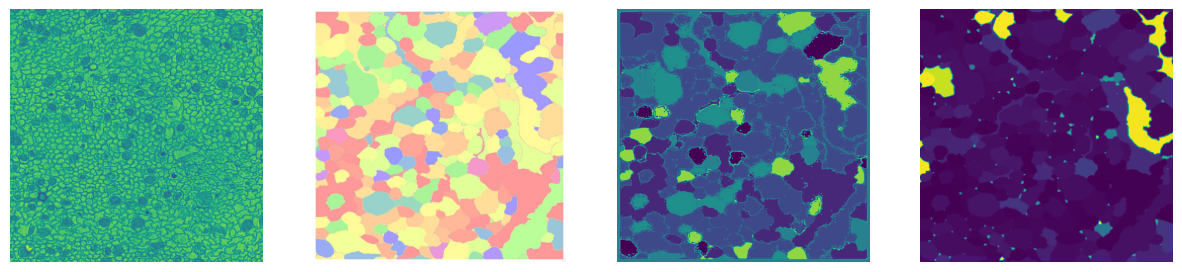

In [14]:
label_class = label_model.predict(np.array(neuron_testimg).reshape(-1, 3)).reshape(944, 944)

raw_index = skimage.transform.resize(raw_index, (256,256))
neuron_index = skimage.transform.resize(neuron_index, (256,256))

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(raw_index)
axes[1].imshow(neuron_testimg)
axes[2].imshow(label_class)
axes[3].imshow(neuron_index)

# for ax in axes:
#     ax.axis('off')

In [15]:
class NeuronDataset(Dataset):
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.index_lst = check_index(self.image_fns)
        self.label_model = label_model

    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        assert index in self.index_lst
        raw_testimg = image_open(train_dir, index, backbone_raw)
        neuron_testimg = image_open(train_dir, index, backbone_neuron)
        label_class = label_model.predict(np.array(neuron_testimg).reshape(-1, 3)).reshape(944, 944)
        neuron_index = np.load(train_dir + "/" + str(index) + backbone_neuronindex)
        neuron_index = skimage.transform.resize(neuron_index, (944, 944))   
        raw_testimg = self.transform(raw_testimg)
        neuron_index = torch.Tensor(neuron_index).long()     
        return raw_testimg, label_class
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)


In [16]:
dataset = NeuronDataset(train_dir, label_model)
print(len(dataset))
raw_image, label_class = dataset[0]
print(raw_image.shape, label_class.shape)

606
torch.Size([3, 944, 944]) (944, 944)


In [17]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [18]:
model = UNet(num_classes=num_classes)

In [19]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape, Y.shape)

Y_pred = model(X)
print(Y_pred.shape)

plt.imshow(Y_pred.cpu().detach().numpy())

606 152
torch.Size([4, 3, 944, 944]) torch.Size([4, 944, 944])


KeyboardInterrupt: 

In [ ]:
# batch_size = 16

# epochs = 10
# lr = 0.01

In [ ]:
# dataset = NeuronDataset(train_dir)
# data_loader = DataLoader(dataset, batch_size=batch_size)
# model = UNet(num_classes=num_classes).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)

# step_losses = []
# epoch_losses = []
# for epoch in tqdm(range(epochs)):
#     epoch_loss = 0
#     for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
#         X, Y = X.to(device), Y.to(device)
#         optimizer.zero_grad()
#         Y_pred = model(X)
#         loss = criterion(Y_pred, Y)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#         step_losses.append(loss.item())
#     epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

: 